# Тематическое моделирование. Библиотека BigARTM

## BigARTM

__Структура библиотеки:__
* Ядро на C++
* Интерфейсы: command line, C++, python
* Передача данных между ядром и интерфейсом: protobuf

__Ключевые особенности:__
* Эффективность [Big]:
    * Параллельная обработка данных (multithread)
    * Необходимость хранения только матрицы $\Phi$, матрицу $\Theta$ хранить необязательно
* Богатая встроенная библиотека регуляризаторов и метрик качества [AR]
* Поддержка многомодальных тематических моделей [TM]

## Установка
Документация: [http://docs.bigartm.org/en/stable/](http://docs.bigartm.org/en/stable/)

Документация по установке: [http://docs.bigartm.org/en/stable/installation](http://docs.bigartm.org/en/stable/installation)
(см. свою ОС)

__Видеоинструкция по установке:__
* [Windows](https://www.coursera.org/learn/unsupervised-learning/lecture/qmsFm/ustanovka-bigartm-v-windows)
* [Linux](https://www.coursera.org/learn/unsupervised-learning/lecture/zPyO0/ustanovka-bigartm-v-linux-mint)
* [Mac OS](https://www.coursera.org/learn/unsupervised-learning/lecture/nuIhL/ustanovka-bigartm-v-mac-os-x)

__Порядок установки:__
1. Python 2.7 + numpy, pandas
1. Скачать релиз / git clone
1. Установка protobuf
1. Для Linux / Mac OS: компиляция ядра
1. Установка python-модуля artm
1. Добавление artm/bin в PATH (или создание ARTM_SHARED_LIBRARY), artm/python в PYTHONPATH

__Документация к python интерфейсу:__ [http://bigartm.readthedocs.io/en/stable/python_interface.html](http://bigartm.readthedocs.io/en/stable/python_interface.html)

## Формат входных данных
### Оформление файла с данными
Наиболее удобный формат: __vowpal wabbit__ - специальная разметка txt-файла:
* каждая строка - один документ
* первое _слово_ в строке - название документа
* далее через пробел следуют пары _слово:количество_ (слова могут повторяться, _:1_ можно опускать, счетчики суммируются)
* _|слово_ - название модальности (после него следуют слова этой модальности)
* если название модальности не указано, слова относятся к модальности @default_class

__Наиболее простой пример:__

     тематическое моделирование это метод статистический анализ текстовый коллекция

__Пример:__

    Лекция1 вы:5 я:3 поэтому:3 иногда |@lecturer Надя Аня |@keywords ТМ ARTM BigARTM |@text тематическое моделирование это метод статистический анализ текстовый коллекция:2 представляться матрица частота слово

### Лекции Постнауки
Материалы сайта [postnauka.ru](http://postnauka.ru)

Две модальности:
* Текст лекции
* Автор

Названия - ссылка на видеолекцию

__Мини-задача:__ сделать тематический рубрикатор Постнауки

### Предобработка
Рекомендуется выполнять предобработку коллекции:
* Лемматизация (приведение слов к начальной форме, рус. - pymorphy2 / mystem, англ. - nltk)
* Удаление стоп слов (предлоги, союзы, общие слова) - по словарям
* Для анализа соц. сетей - оставлять слова только из словаря
* Фильтрация словаря (удаление очень редких и очень частых слов) - умеет BigARTM

### Импорт данных
BigARTM преобразует данные во внутренний формат - батчи. Батчи сохраняются в заданную директорию и управляются объектом класса BatchVectorizer.

In [28]:
import artm
import glob
import os

In [29]:
source_file = os.path.join("data", "lectures.txt")
batches_folder = "lectures_batches"
if not glob.glob(os.path.join(batches_folder, "*")):
    batch_vectorizer = artm.BatchVectorizer(data_path=source_file, 
                                            data_format="vowpal_wabbit", 
                                            target_folder=batches_folder,
                                            batch_size=100)
else:
    batch_vectorizer = artm.BatchVectorizer(data_path=batches_folder,
                                            data_format='batches')

При первом выполнении этой ячейки в директории lectures_batches появятся файлы с расширением .batch, в следующие разы батчи будут считываться уже из этой директории.

### Сборка словаря

После преобразования данных нужно собрать словарь, с которым будет работать модель.

In [30]:
dict_name = os.path.join(batches_folder, "dict.txt")
dictionary = artm.Dictionary(name="dictionary")
if not os.path.exists(dict_name):
    dictionary.gather(batches_folder)
    dictionary.save_text(dict_name)
else:
    dictionary.load_text(dict_name)

При первом выполнении этой ячеки в директории lectures_batches появится текстовый файл со словарем, в следующие разы словарь будет считываться из этого файла.

## Построение модели
В BigARTM реализованы два варианта обучения тематической модели: offline и online.

Обучение offline:
* выполняется много проходов по коллекции (обычно 20-30)
* при каждом проходе по коллекции - несколько проходов по каждому батчу
* при каждом проходе по батчу - вычисление локальной $\Theta$ (с регуляризацией) и обновление глобальной $\Phi$
* после прохода по коллекции - регуляризация глобальной $\Phi$.

Обучение online:
* один или несколько проходов по коллекции
* для улучшения сходимости добавляются параметры сглаживания
* подходит для очень больших коллекций

In [31]:
scores_list = []
scores_list.append(artm.PerplexityScore(name='PerplexityScore'))  # перплексия (перенормированное правдоподобие)
scores_list.append(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="@text"))   # разреженность Phi
scores_list.append(artm.SparsityThetaScore(name='SparsityThetaScore'))   # разреженность Theta
scores_list.append(artm.TopTokensScore(name="top_words", 
                                          num_tokens=15, 
                                          class_id="@text"))  # для печати наиболее вероятных терминов темы
                                                                           

In [32]:
T = 30   # количество тем
model_artm = artm.ARTM(num_topics=T,  # число тем
                       class_ids={"@text":1, "@author":5},   # число после названия модальностей - это их веса
                       num_document_passes=10,   # сколько делать проходов по документу
                       cache_theta=True,   # хранить или нет глоабльную матрицу Theta
                       reuse_theta=False,   # если Theta хранится, нужно ли ее вновь инициализировать при каждом проходе
                       theta_columns_naming="title",   # как именовать столбцы в матрице Theta
                       seed=789,   # random seed
                       scores=scores_list)  # метрики качества

Модель нужно инициализировать с помощью словаря. Затем мы сможем ее обучить:

In [33]:
model_artm.initialize(dictionary)
%time model_artm.fit_offline(batch_vectorizer=batch_vectorizer, \
                             num_collection_passes=30)

Wall time: 13.9 s


Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

In [34]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn

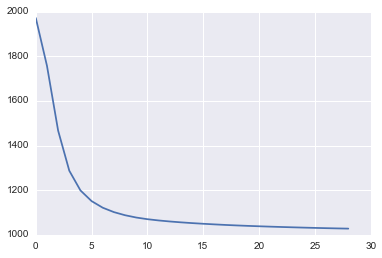

In [35]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value[1:]) 

In [36]:
print "Perplexity:", model_artm.score_tracker["PerplexityScore"].last_value

Perplexity: 1027.70824476


Выведем топы слов:

In [37]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    for word in model_artm.score_tracker["top_words"].last_tokens[topic_name]:
        print word,
    print

topic_0:  это что который быть этот мозг человек или мочь заболевание пациент болезнь система очень как
topic_1:  что это быть этот который материал как мочь такой для можно свет очень свойство они
topic_2:  быть что звезда это этот черный дыра который объект такой время они как очень скорость
topic_3:  быть что это этот который данные для как сеть они такой компьютер информация задача мочь
topic_4:  культура это быть который этот что язык как век христианский восток они другой литература текст
topic_5:  быть что это этот который они год как очень мочь такой весь вид животное организм
topic_6:  человек что это который этот быть как они мочь тот такой или поведение для другой
topic_7:  что быть это этот который пространство как структура мочь такой если они какой-то один самый
topic_8:  быть что это этот как ребенок который человек они она очень женщина такой когда потому
topic_9:  это быть что этот который квантовый поле частица такой как мочь магнитный электрон атом энергия
topic_10: 

Разреженность матриц:

In [38]:
print "Phi sparsity:",model_artm.score_tracker["SparsityPhiScore"].last_value
print "Theta sparsity:", model_artm.score_tracker["SparsityThetaScore"].last_value

Phi sparsity: 0.825863182284
Theta sparsity: 0.0


В темах много общеупотребительных слов (так называемой фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы $\Phi$. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [39]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', 
                                                            tau=-5*1e5, 
                                                            dictionary="dictionary",
                                                            class_ids=["@text"]))

In [40]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, 
                       num_collection_passes=15)

In [41]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    for word in model_artm.score_tracker["top_words"].last_tokens[topic_name]:
        print word,
    print

topic_0:  болезнь заболевание пациент лечение врач боль препарат медицинский иммунный сон больной диагностика синдром наследственный сосуд
topic_1:  оптический полимер лазерный углеродный электроника полимерный собственник микроскоп имущество двумерный транзистор кремний нитрид волокно электричество
topic_2:  черный дыра нейтронный рентгеновский относительность сверхновый компактный астрономия вспышка всплеск часы светить отсчет обсерватория горизонт
topic_3:  данные компьютер сеть машина алгоритм вычислительный пользователь нейронный программный программирование доверие кодирование репутация затрата подчиненный
topic_4:  христианский восток письменность христианство христианин арабский рукопись сирийский араб армянский кавказский коптский ближний быт грузинский
topic_5:  микроорганизм озеро метан климат микроб хищник экосистема экология многоклеточный микробный дно радиация углекислый яйцо скелет
topic_6:  трудность коллективный личностный поведенческий стресс агрессия агрессивный диа

In [42]:
# еще раз посмотрим на разреженность
print "Phi sparsity:", model_artm.score_tracker["SparsityPhiScore"].last_value
print "Theta sparsity:", model_artm.score_tracker["SparsityThetaScore"].last_value

Phi sparsity: 0.980155986883
Theta sparsity: 0.784490740741


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

### Сохранение и загрузка модели

In [43]:
model_artm.save("my_model")

In [44]:
#model_artm.load("my_model")

### Работа с моделью

In [45]:
phi = model_artm.get_phi(class_ids=["@text"])

In [46]:
phi.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29
аллель,0,0,0,0.000000,0.000000,0,0,0,0,0,...,0,0,0,0.000000,0,0,0,0,0,0
халиф,0,0,0,0.000000,0.001039,0,0,0,0,0,...,0,0,0,0.000000,0,0,0,0,0,0
прокопович,0,0,0,0.000000,0.000000,0,0,0,0,0,...,0,0,0,0.000000,0,0,0,0,0,0
клетка,0,0,0,0.000000,0.000000,0,0,0,0,0,...,0,0,0,0.133672,0,0,0,0,0,0
передаваемый,0,0,0,0.000277,0.000000,0,0,0,0,0,...,0,0,0,0.000000,0,0,0,0,0,0


Тематические профили документов:

In [47]:
theta = model_artm.get_theta()
theta.head()

,http://postnauka.ru/video/19330,http://postnauka.ru/video/19357,http://postnauka.ru/video/19371,http://postnauka.ru/video/19436,http://postnauka.ru/video/19451,http://postnauka.ru/video/19453,http://postnauka.ru/video/19456,http://postnauka.ru/video/19457,http://postnauka.ru/video/19458,http://postnauka.ru/video/19459,...,http://postnauka.ru/video/12739,http://postnauka.ru/video/12740,http://postnauka.ru/video/12898,http://postnauka.ru/video/12904,http://postnauka.ru/video/12971,http://postnauka.ru/video/12974,http://postnauka.ru/video/13041,http://postnauka.ru/video/13042,http://postnauka.ru/video/13043,http://postnauka.ru/video/13092
topic_0,0.00000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,0.119048,...,0.000000,0,0,0,0,0.3125,0,0,0,0.423077
topic_1,0.00000,0.000000,0,0,0,0,0.048780,0.071429,0.113636,0.000000,...,0.000000,0,0,0,0,0.2500,0,0,0,0.000000
topic_2,0.00000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,0.000000,...,0.014085,0,0,0,0,0.0000,0,0,0,0.000000
topic_3,0.02439,0.000000,0,0,0,0,0.073182,0.071429,0.000000,0.000000,...,0.000000,0,0,0,0,0.0000,0,0,0,0.000000
topic_4,0.00000,0.018182,0,0,0,0,0.000000,0.000000,0.000000,0.000000,...,0.309859,0,0,0,0,0.0000,0,0,0,0.000000


Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [48]:
theta_test = model_artm.transform(batch_vectorizer)

Параметры модели:

In [49]:
print model_artm.class_ids
print model_artm.topic_names
print model_artm.score_tracker.keys()
print model_artm.regularizers.data.keys()

{'@text': 1, '@author': 5}
[u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29']
['PerplexityScore', 'SparsityPhiScore', 'SparsityThetaScore', 'top_words']
['SparsePhi']


### Посмотрим, что получилось

In [50]:
import numpy as np
import pandas as pd

In [51]:
def print_topic(model, topic_name):
    theta = model.get_theta()
    docs = theta.ix[topic_name].sort_values()[:-10:-1]
    
    print "------", topic_name, "------"
    print "Терминология:", " ".join(model.score_tracker["top_words"].last_tokens[topic_name][:10])
    print "Лекции:"
    for link in docs.index:
        print "*", link

In [52]:
print_topic(model_artm, model_artm.topic_names[12])

------ topic_12 ------
Терминология: философия социология философский философ социологический социолог платон повседневность кант виталий
Лекции:
* http://postnauka.ru/video/2955
* http://postnauka.ru/video/20390
* http://postnauka.ru/video/6380
* http://postnauka.ru/video/14297
* http://postnauka.ru/video/6725
* http://postnauka.ru/video/3405
* http://postnauka.ru/video/8623
* http://postnauka.ru/video/2526
* http://postnauka.ru/video/3628


Поиск похожих авторов:

In [53]:
authors_phi = model_artm.get_phi(class_ids=["@author"])

In [54]:
### Профили авторов:
authors_topics = authors_phi.values
authors_topics /= authors_topics.sum(axis=1)[:, np.newaxis]

In [55]:
authors_corr = pd.DataFrame(data=np.corrcoef(authors_topics),
                            index=authors_phi.index,
                            columns=authors_phi.index)

In [56]:
authors_corr.head()

,Андрей_Лукашов,Татьяна_Ребеко,Кирилл_Зыбин,Роберт_Лэнгер,Валерий_Рубаков,Александр_Петренко,Рой_Глаубер,Алексей_Муравьёв,Константин_Звездин,Александр_Парфенов,...,Пётр_Турчин,Юрий_Рогулёв,Екатерина_Болтунова,Дэвид_Кларк,Алексей_Малашенко,Ирина_Левонтина,Андрей_Коротаев,Александр_Беленький,Павел_Степанцов,Дэвид_Гросс
Андрей_Лукашов,1.000000,-0.034488,-0.034483,-0.034483,-0.047304,-0.034483,-0.034483,-0.034483,-0.034504,-0.034483,...,-0.034483,-0.035156,-0.034483,-0.034483,-0.034483,-0.034483,-0.034483,-0.034483,-0.034483,-0.034483
Татьяна_Ребеко,-0.034488,1.000000,-0.034488,-0.034488,-0.047312,-0.034488,-0.034488,-0.034488,-0.034510,-0.034488,...,-0.034488,-0.035162,-0.034488,-0.034488,-0.034488,-0.034488,-0.034488,-0.034488,-0.034488,-0.034489
Кирилл_Зыбин,-0.034483,-0.034488,1.000000,-0.034483,-0.047304,-0.034483,-0.034482,-0.034483,-0.034504,-0.034483,...,-0.034483,-0.035156,-0.034483,-0.034483,-0.034483,-0.034483,-0.034483,-0.034483,-0.034483,1.000000
Роберт_Лэнгер,-0.034483,-0.034488,-0.034483,1.000000,-0.047304,-0.034483,-0.034483,-0.034483,-0.034504,-0.034483,...,-0.034483,-0.035156,-0.034483,-0.034483,1.000000,-0.034483,-0.034483,1.000000,-0.034483,-0.034483
Валерий_Рубаков,-0.047304,-0.047312,-0.047304,-0.047304,1.000000,-0.047304,-0.047304,-0.047304,-0.047333,-0.047304,...,-0.047304,-0.048227,-0.047304,-0.047304,-0.047304,-0.047304,-0.047304,-0.047304,-0.047304,-0.047297


In [57]:
authors_corr[u"Валерий_Рубаков"].sort_values()[:-20:-1]

Валерий_Рубаков          1.000000
Дмитрий_Горбунов         0.879814
Михаил_Фейгельман        0.879814
Николай_Мощевитин        0.879814
Макс_Тегмарк             0.879814
Сергей_Ландо             0.879814
Сергей_Нечаев            0.879814
Олег_Верходанов          0.879814
Михаил_Эпштейн           0.879814
Александра_Скрипченко    0.879814
Алексей_Моисеев          0.879814
Мэтью_Басс               0.879814
Лайман_Пейдж             0.879814
Илья_Щуров               0.879814
Алексей_Старобинский     0.879814
Григорий_Кабатянский     0.746174
Григорий_Юдин            0.687089
Сергей_Кетов             0.444698
Михаил_Данилов           0.444698
Name: Валерий_Рубаков, dtype: float64

# Профилирование пользователей соц. сетей в BigARTM

__Исходные данные (NUS-MSS):__
* Пользователи с аккаунтом в трех соц. сетях: Twitter, Instagram, Fousquare
* Атрибуты пользователей: пол, возрастная группа, уровень образования, семейное положение, уровень дохода
* Сообщения пользователей:
    * Текст (с хештегами, url, ссылками на пользователей...)
    * Изображения
    * Метки локации
    * Метки времени
    
__Задачи:__
* предсказать атрибут пользователя по его сообщениям
* исследовать, чем отличается активность пользователей, имеющих разные значения атрибута

$\rightarrow$ __Профилирование пользователей:__

поиск скрытых представлений пользователей, характеризующих их поведение в сети

## Профилирование с помощью тематического моделирования
Поиск тем в соц. сетях

Документы?

__Документы:__
пользователи
* агрегируем все сообщения одного пользователя
* заодно решаем проблему коротких текстов

Модальности?

__Модальности:__
* Текст (@text)
* Хештеги (@hashtags)
* Категории изображений (@images)
* Категории локаций (@venue_categories)
* Дни написания сообщений (@day)
_________
* Атрибут 


Vowpal wabbit:
* london_users.txt - сообщения пользователей
* london_users_train.txt - сообщения пользователей и пол (обучающая выборка)
* london_users_test.txt - сообщения пользователей (тестовая выборка)

Предобработка текстов:
* удаление из текстов ссылок и хештегов
* лемматизация
* удаление стоп-слов, фильтрация слов по словарю (оставляем только словарные слова)
* удаление коротких слов (меньше трех букв)

Будем анализировать пол (больше всего пользователей):

In [58]:
import collections
london_train = pd.read_csv(os.path.join("data", "LondonTrain.csv"))
for column in london_train.columns[3:]:
    print column, ":", collections.Counter(london_train[column].dropna())

gender : Counter({'male': 2282, 'female': 966})
realAge : Counter()
ageGroup : Counter()
relationship : Counter({'single': 194, 'married': 179, 'in a relationship': 86})
educationLevel : Counter({'undergraduate': 540, 'school': 176, 'college': 134, 'graduate': 24})
occupation : Counter({'management': 356, 'arts, design, entertainment, sports, and media': 161, 'office and administrative support': 59, 'computer and mathematical': 58, 'personal care and service': 52, 'archetecture and engineering': 51, 'sales and related': 41, 'protective service': 37, 'food preparation and service related': 33, 'education, training, and library': 25, 'healthcare support': 22, 'transportation and material moving': 18, 'legal': 11, 'production': 8, 'business and financial operations': 8, 'healthcare practitioners and technical': 5, 'farming, fishing and forestry': 5, 'life, physical, and social science': 5, 'construction and extraction': 4, 'building and grounds cleaning and maintenance': 4, 'community and

In [59]:
london_test = pd.read_csv(os.path.join("data", "LondonTest.csv"))

Импортируем данные:

In [60]:
batch_vectorizer = artm.BatchVectorizer(data_path="data/london_users_train.txt",\
                                        data_format="vowpal_wabbit",\
                                        target_folder="train_batches")
dictionary = artm.Dictionary(name="dictionary")
dictionary.gather(batch_vectorizer.data_path)

In [61]:
batch_vectorizer_test = artm.BatchVectorizer(data_path="data/london_users_test.txt",\
                                        data_format="vowpal_wabbit",\
                                        target_folder="test_batches")

Создаем класс модели:

In [62]:
modals = ["@text", "@day", "@venue_categories", "@images", "@hashtags"]
T = 50
model_artm = artm.ARTM(num_topics=T, 
                      class_ids={"@text":1, "@day":1, "@venue_categories":1, \
                                 "@venue_name":1, "@images":1, "@hashtags":1,
                                 "gender":0},   # пока анализируем только сообщения
                      num_document_passes=10,
                      seed=867)
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
for mod in modals:
    model_artm.scores.add(artm.TopTokensScore(name="top_"+mod[1:], 
                                              num_tokens=15, 
                                              class_id=mod))

Обучим модель:

In [63]:
model_artm.initialize(dictionary)
%time model_artm.fit_offline(batch_vectorizer=batch_vectorizer, \
                             num_collection_passes=20)

Wall time: 1min 47s


Что будем делать с обученной моделью?

Посмотрим темы:

In [64]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    print ", ".join(model_artm.score_tracker["top_text"].last_tokens[topic_name])

topic_0:  badge, ale, fund, brew, aged, barrel, patient, brewing, chic, map, pumpkin, global, science, specialist, bock
topic_1:  automatically, unfollowed, dashboard, preview, shoot, hah, owl, tiffany, sunny, merry, boo, color, clear, hoot, loud
topic_2:  photography, cinema, screening, lightroom, hull, press, giant, thats, bet, stadium, flower, enjoying, saint, score, leather
topic_3:  quiz, platform, connected, express, zombie, midland, cathedral, daughter, added, delay, wharf, canary, river, science, central
topic_4:  fulham, score, lad, banter, current, scored, joke, sold, harry, condition, genuinely, cloudy, scene, transfer, sunrise
topic_5:  search, agency, technique, croydon, workshop, appreciate, creative, rate, impact, hub, economy, speaker, library, exciting, midland
topic_6:  hall, tax, writing, teacher, financial, tory, policy, pupil, labour, wigan, audience, conservative, reform, duty, parliament
topic_7:  pitch, berlin, added, subject, bill, studio, cloud, panel, apply, 

In [65]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    print ", ".join(model_artm.score_tracker["top_hashtags"].last_tokens[topic_name])

topic_0:  digitalhealth, amsterdam, leweb, london, vatmoss, diffmed, health2eu, swfintech, blackfriday, kfdublin, opendata, christmas, health, healthcare, bristol
topic_1:  google, ux, design, taeny, seo, hootamb, swcork, beauty, hootsuitelife, fergusonoctober, hootlove, ferguson, photoshoot, apple, hormonestheseries2
topic_2:  tvtag, london, streetphotography, xfactor, londra, streetlife, christmas, lff, vacation, saintsfc, wba, nyc, imaceleb, holidaysarecoming, halloween
topic_3:  fb, bangladesh, breaking, gadvhaiti, indyref, london, biffybarras, tbt, mediaincontext, holidays, spain, morocco, party, selfie, wikipedia
topic_4:  hipstamatic, watfordfc, sh, ffc, oggl, ripon, lufc, canucks, amsterdam, arsenal, afc, instasize, toweroflondon, myabviewnow, believe
topic_5:  xfactor, searchenginejournal, birmingham, searchenginewatch, tedxbrum, igersbirmingham, streetart, brightonseo, ilovebrum, graffiti, brumfotos, lunch, christmasinbham, christmas, socialselling
topic_6:  bbcqt, lifeyouwan

In [66]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    print ", ".join(model_artm.score_tracker["top_venue_categories"].last_tokens[topic_name])

topic_0:  Home_(private), Neighborhood, City, Office, Rest_Area, General_Travel, Town, Fast_Food_Restaurant, Building, Gas_Station_/_Garage, Coworking_Space, Other_Great_Outdoors, Garden, Moving_Target, Park
topic_1:  Airport, Mall, Hotel, Japanese_Restaurant, Church, Café, Convention_Center, Noodle_House, Movie_Theater, Burger_Joint, Italian_Restaurant, Harbor_/_Marina, American_Restaurant, Street, Playground
topic_2:  Movie_Theater, Theater, Art_Gallery, Pub, Performing_Arts_Venue, American_Restaurant, Concert_Hall, Soccer_Stadium, Bar, Office, Hotel, Art_Museum, Palace, Neighborhood, Coffee_Shop
topic_3:  Train_Station, Pub, Office, Bar, Platform, Hotel, Coffee_Shop, Hotel_Bar, Plaza, Church, Café, Gym_/_Fitness_Center, Home_(private), Cocktail_Bar, Grocery_Store
topic_4:  Pub, Soccer_Stadium, Sports_Bar, Bar, Theme_Park_Ride_/_Attraction, Nightclub, Student_Center, Coffee_Shop, Train_Station, Café, Chinese_Restaurant, American_Restaurant, Fast_Food_Restaurant, Concert_Hall, Church


In [67]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    print ", ".join(model_artm.score_tracker["top_images"].last_tokens[topic_name])

topic_0:  bow-tie, electric_guitar, ski_mask, piano_accordion, street_sign, fire_engine, wok, king_snake, stupa, isopod, soda_bottle, purse, shopping_basket, scorpion, handkerchief
topic_1:  Sus_scrofa, crane, ski_mask, brassiere, cauldron, hair_slide, buckler, Doberman_pinscher, pencil_eraser, goblet, internet_site, nipple, ice_lolly, sleeping_bag, Ambystoma_maculatum
topic_2:  crane, brassiere, motor_scooter, transverse_flute, eating_house, merry-go-round, eel, Aepyceros_melampus, piano_accordion, pickelhaube, packet, tiger_cat, jellyfish, slug, Cebus_capucinus
topic_3:  pug-dog, picture_palace, vase, merry-go-round, Cancer_irroratus, space_bar, bucket, feather_boa, steel_drum, wig, quill_pen, shower_cap, purse, membranophone, drumstick
topic_4:  Sus_scrofa, ski_mask, buckler, bow-tie, bearskin, barracouta, lawn_mower, tow_truck, cauldron, German_shepherd_dog, stage, crawdaddy, safety_pin, oxygen_mask, Lepisosteus_osseus
topic_5:  Sus_scrofa, picture_palace, cauldron, stage, crawdadd

Профили пользователей:

In [68]:
model_artm.theta_columns_naming = "title"
theta = model_artm.transform(batch_vectorizer)

In [69]:
theta.T.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_40,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49
1056e82616e9a27eee13cbcb045f6d7b,5.551455e-05,3.071664e-04,0.000002,0.000024,1.028577e-02,0.001795,0.000016,0.000028,0.000063,4.506726e-04,...,0.025787,1.095047e-02,0.010889,0.000011,2.172080e-04,0.000010,0.016067,0.000002,0.008240,0.000999
3914aa074b505528c26d8af0659e57b7,1.403768e-05,7.939011e-05,0.116985,0.000048,1.291078e-06,0.000765,0.000101,0.000092,0.000027,4.835771e-05,...,0.000718,6.250591e-04,0.000430,0.002373,4.761821e-06,0.176148,0.008867,0.000129,0.000173,0.000015
529b1ce53166eea850052a1f14e4906a,2.227682e-02,1.489825e-02,0.023176,0.017778,1.215842e-02,0.021679,0.017723,0.028195,0.017146,1.748337e-02,...,0.016357,1.665150e-02,0.016820,0.037791,1.647421e-02,0.015464,0.016636,0.020575,0.022324,0.017877
bcc012f1342f85308443dfeb187e5966,3.612599e-07,2.870211e-07,0.000026,0.000061,6.354963e-08,0.000002,0.000005,0.000013,0.011792,5.454961e-07,...,0.000001,8.304287e-07,0.000001,0.391931,2.243911e-07,0.004173,0.000467,0.000297,0.019096,0.000721
b4a6df760e1615fbb925cc00aa7c6519,6.742258e-02,6.019495e-04,0.001521,0.000556,2.648560e-05,0.000149,0.000926,0.000791,0.000414,5.805595e-04,...,0.000241,2.782722e-04,0.000248,0.000046,9.885131e-07,0.000012,0.000082,0.000718,0.000150,0.008369


In [70]:
theta.max(axis=0).head(20)

1056e82616e9a27eee13cbcb045f6d7b    0.853906
3914aa074b505528c26d8af0659e57b7    0.276507
529b1ce53166eea850052a1f14e4906a    0.052626
bcc012f1342f85308443dfeb187e5966    0.567928
b4a6df760e1615fbb925cc00aa7c6519    0.873678
111ef6d7aa963055d7b847e043f9535a    0.393274
a9cb7444b4e32b06fd4f60c00cc5a688    0.274372
c25e00d759e245a8087baed1cb6e410e    0.129995
b30de9fd025b2cc8a176bb0658383ffb    0.053093
65cf06a5ea12f731df97e80091971470    0.493953
505de7a3405166acc58fe36f26c4f4e8    0.035995
dbadfe9ff0e10489cb5fb20da2889497    0.044111
d0a028ed075052809ff5488ad0dd119a    0.041979
bbfd350b691130c61ba42f2dcc712526    0.582588
7761a4aec64be88dc8ccf7dbcfcf0b63    0.126359
f4e7c9f86944b27e3a1954106125c095    0.072569
ba1bef15978c086add26e115c734f525    0.502689
a35a322cc4c74e315d50ffbb96849c83    0.264407
029603ec9fc5764928d2e58ca078edfd    0.403969
ad1b20b6024d5ec4b13e9747c48087c7    0.642019
dtype: float32

Интерпретировать сложно :(

Профили пользователей:

In [71]:
theta_2 = theta.T
theta_2["row ID"] = theta_2.index
theta_2.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49,row ID
1056e82616e9a27eee13cbcb045f6d7b,5.551455e-05,3.071664e-04,0.000002,0.000024,1.028577e-02,0.001795,0.000016,0.000028,0.000063,4.506726e-04,...,1.095047e-02,0.010889,0.000011,2.172080e-04,0.000010,0.016067,0.000002,0.008240,0.000999,1056e82616e9a27eee13cbcb045f6d7b
3914aa074b505528c26d8af0659e57b7,1.403768e-05,7.939011e-05,0.116985,0.000048,1.291078e-06,0.000765,0.000101,0.000092,0.000027,4.835771e-05,...,6.250591e-04,0.000430,0.002373,4.761821e-06,0.176148,0.008867,0.000129,0.000173,0.000015,3914aa074b505528c26d8af0659e57b7
529b1ce53166eea850052a1f14e4906a,2.227682e-02,1.489825e-02,0.023176,0.017778,1.215842e-02,0.021679,0.017723,0.028195,0.017146,1.748337e-02,...,1.665150e-02,0.016820,0.037791,1.647421e-02,0.015464,0.016636,0.020575,0.022324,0.017877,529b1ce53166eea850052a1f14e4906a
bcc012f1342f85308443dfeb187e5966,3.612599e-07,2.870211e-07,0.000026,0.000061,6.354963e-08,0.000002,0.000005,0.000013,0.011792,5.454961e-07,...,8.304287e-07,0.000001,0.391931,2.243911e-07,0.004173,0.000467,0.000297,0.019096,0.000721,bcc012f1342f85308443dfeb187e5966
b4a6df760e1615fbb925cc00aa7c6519,6.742258e-02,6.019495e-04,0.001521,0.000556,2.648560e-05,0.000149,0.000926,0.000791,0.000414,5.805595e-04,...,2.782722e-04,0.000248,0.000046,9.885131e-07,0.000012,0.000082,0.000718,0.000150,0.008369,b4a6df760e1615fbb925cc00aa7c6519


In [72]:
theta_train = theta_2.merge(london_train[["row ID", "gender"]], on="row ID")
theta_train.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49,row ID,gender
0,5.551455e-05,3.071664e-04,0.000002,0.000024,1.028577e-02,0.001795,0.000016,0.000028,0.000063,4.506726e-04,...,0.010889,0.000011,2.172080e-04,0.000010,0.016067,0.000002,0.008240,0.000999,1056e82616e9a27eee13cbcb045f6d7b,male
1,1.403768e-05,7.939011e-05,0.116985,0.000048,1.291078e-06,0.000765,0.000101,0.000092,0.000027,4.835771e-05,...,0.000430,0.002373,4.761821e-06,0.176148,0.008867,0.000129,0.000173,0.000015,3914aa074b505528c26d8af0659e57b7,female
2,2.227682e-02,1.489825e-02,0.023176,0.017778,1.215842e-02,0.021679,0.017723,0.028195,0.017146,1.748337e-02,...,0.016820,0.037791,1.647421e-02,0.015464,0.016636,0.020575,0.022324,0.017877,529b1ce53166eea850052a1f14e4906a,male
3,3.612599e-07,2.870211e-07,0.000026,0.000061,6.354963e-08,0.000002,0.000005,0.000013,0.011792,5.454961e-07,...,0.000001,0.391931,2.243911e-07,0.004173,0.000467,0.000297,0.019096,0.000721,bcc012f1342f85308443dfeb187e5966,male
4,6.742258e-02,6.019495e-04,0.001521,0.000556,2.648560e-05,0.000149,0.000926,0.000791,0.000414,5.805595e-04,...,0.000248,0.000046,9.885131e-07,0.000012,0.000082,0.000718,0.000150,0.008369,b4a6df760e1615fbb925cc00aa7c6519,male


Оформим в функцию:

In [73]:
def get_theta_with_gender(model_artm, batch_vectorizer, london_groundtruth):
    model_artm.theta_columns_naming = "title"
    theta = model_artm.transform(batch_vectorizer)
    theta_2 = theta.T
    theta_2["row ID"] = theta_2.index
    theta_2.head()
    theta_train = theta_2.merge(london_groundtruth[["row ID", "gender"]], on="row ID")
    return theta_train

In [74]:
theta_test = get_theta_with_gender(model_artm, batch_vectorizer_test, london_test)
theta_test.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49,row ID,gender
0,0.020989,0.024917,1.755437e-02,0.020656,1.755586e-02,1.794804e-02,0.022473,0.020354,0.017626,0.016571,...,0.019563,0.046218,0.013170,0.014064,0.018487,0.016967,0.021893,0.023644,1518476681eb6faca572810e975589fc,female
1,0.010152,0.055102,5.645168e-05,0.004861,4.669917e-06,4.948882e-03,0.002757,0.000055,0.000973,0.000225,...,0.001147,0.011750,0.030127,0.000061,0.069329,0.000047,0.000003,0.042757,34eb37aad29f7d1498b93ed21a4674e3,female
2,0.021606,0.020235,1.943818e-02,0.020305,1.935029e-02,1.982816e-02,0.020431,0.020249,0.020952,0.019050,...,0.019761,0.019711,0.019432,0.018912,0.020117,0.019760,0.019556,0.020329,c27f4d0da1621bc3ab9cd90d16944d8d,female
3,0.007073,0.017759,8.144327e-03,0.012777,2.549726e-01,7.434667e-03,0.015602,0.010650,0.022360,0.020760,...,0.017812,0.006084,0.054844,0.027096,0.008199,0.006888,0.004643,0.004691,bf5be0e65f24b55393a79115ce56e7bd,male
4,0.002048,0.069012,2.254601e-07,0.004073,7.349436e-07,3.405318e-07,0.000816,0.000011,0.000075,0.007503,...,0.001699,0.001289,0.011664,0.253653,0.003734,0.000008,0.426828,0.000054,b4b4cbb33a9e062f2a48ab964ddd0b96,male


Предсказания:

In [75]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

In [76]:
rf = KNeighborsClassifier()
rf.fit(theta_train[model_artm.topic_names], 
       theta_train["gender"].map({"female":0, "male":1}))
predict = rf.predict(theta_test[model_artm.topic_names])
f1_score(theta_test["gender"].map({"female":0, "male":1}), predict)

0.73913043478260854

Визуализация:

In [77]:
from sklearn.manifold import MDS

In [78]:
mds = MDS()
features = mds.fit_transform(theta_train[model_artm.topic_names].values[:1000, :].astype(np.float64))

C:\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


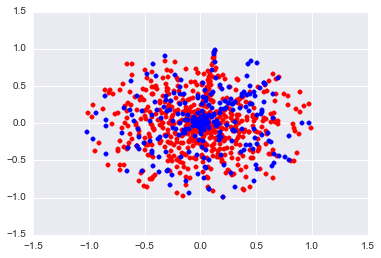

In [79]:
index = (theta_train["gender"]=="male")[:1000].values
plt.scatter(features[index, 0], features[index, 1], color="red")
index = (theta_train["gender"]=="female")[:1000].values
plt.scatter(features[index, 0], features[index, 1], color="blue")

Строим модель, которая учитывает пол при моделировании тем:

In [102]:
modals = ["@text", "@day", "@venue_categories", "@images", "@hashtags"]
T = 50
model_artm = artm.ARTM(num_topics=T, 
                      class_ids={"@text":1, "@day":1, "@venue_categories":1, \
                                 "@venue_name":1, "@images":1, "@hashtags":1,
                                 "gender":100},
                      num_document_passes=10,
                      seed=867)
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
for mod in modals:
    model_artm.scores.add(artm.TopTokensScore(name="top_"+mod[1:], num_tokens=15, class_id=mod))

In [103]:
model_artm.initialize(dictionary)
%time model_artm.fit_offline(batch_vectorizer=batch_vectorizer, \
                             num_collection_passes=20)

Wall time: 1min 48s


Чем отличаются предыдущая модель и эта?

In [104]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    print ", ".join(model_artm.score_tracker["top_text"].last_tokens[topic_name])

topic_0:  badge, ale, brew, brewery, pumpkin, rum, aged, brewing, fund, barrel, chic, patient, donation, dorado, pale
topic_1:  dashboard, language, preview, shoot, tiffany, owl, hah, clear, writing, protest, boo, basically, fiction, hoot, loud
topic_2:  screening, cinema, press, dance, cancer, sing, empire, enjoying, exhibition, flower, finger, watched, colour, singing, pair
topic_3:  ran, pace, traveled, bike, route, cloud, delay, platform, connected, daughter, bound, wife, express, gym, quiz
topic_4:  fulham, lad, score, scored, decent, banter, cottage, stadium, joke, sold, current, genuinely, scene, loan, derby
topic_5:  workshop, search, technique, croydon, impact, exciting, hub, creative, ace, library, inspiring, speaker, rate, midland, agency
topic_6:  teacher, writing, tho, jake, sausage, pupil, gym, block, nearly, literally, straight, ugh, jumper, wigan, stupid
topic_7:  berlin, wrote, subject, bill, yea, faith, computer, hack, cloud, chip, privacy, camera, net, type, device
t

In [105]:
mds = MDS()
features = mds.fit_transform(theta_train[model_artm.topic_names].values[:1000, :].astype(np.float64))

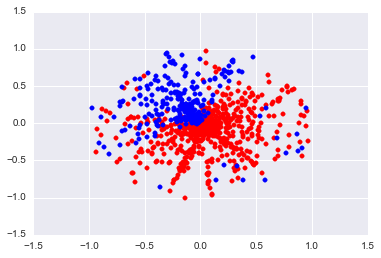

In [106]:
index = (theta_train["gender"]=="male")[:1000].values
plt.scatter(features[index, 0], features[index, 1], color="red")
index = (theta_train["gender"]=="female")[:1000].values
plt.scatter(features[index, 0], features[index, 1], color="blue")

In [85]:
theta_train = get_theta_with_gender(model_artm, batch_vectorizer, london_train)
theta_test = get_theta_with_gender(model_artm, batch_vectorizer_test, london_test)

In [86]:
rf = KNeighborsClassifier()
rf.fit(theta_train[model_artm.topic_names], 
       theta_train["gender"].map({"female":0, "male":1}))
predict = rf.predict(theta_test[model_artm.topic_names])
f1_score(theta_test["gender"].map({"female":0, "male":1}), predict)

0.76068376068376076

BigARTM умеет предсказывать значения класса:

$p(g|d) = \sum_{t} p(g|t) p(t|d) = \sum_{t} \phi_{gt} \theta_{td}$

In [87]:
predict_artm = model_artm.transform(batch_vectorizer_test, predict_class_id="gender").T

In [88]:
predict_artm["row ID"] = predict_artm.index
predict_artm_with_gender = predict_artm.merge(london_test[["gender", "row ID"]], 
                                              on="row ID")

In [89]:
f1_score(predict_artm_with_gender["gender"].map({"female":0, "male":1}), 
         predict_artm_with_gender["male"]>0.5)

0.78294573643410859

Посмотрим, как модель соотносит темы и пол пользователя:

In [90]:
phi = model_artm.get_phi(class_ids=["gender"])

In [91]:
phi

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_40,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49
male,0.992702,0.999996,0.00001,1.000000e+00,1.000000e+00,0.000003,0.999988,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1,1.000000e+00,1.000000e+00,2.436286e-15,5.211973e-07,1.109299e-13,1.000000e+00,1.000000e+00
female,0.007298,0.000004,0.99999,4.372152e-16,5.825128e-11,0.999997,0.000012,9.047643e-14,1.760400e-10,9.160315e-13,...,7.161265e-11,1.903917e-08,0,6.371013e-10,9.960633e-10,1.000000e+00,9.999995e-01,1.000000e+00,9.172352e-10,8.733173e-13


In [92]:
for topic_name in model_artm.topic_names:
    print phi[topic_name].argmax(), "(%3f): " % phi[topic_name].max(),
    print ", ".join(model_artm.score_tracker["top_text"].last_tokens[topic_name])

male (0.992702):  badge, ale, brew, brewery, pumpkin, rum, aged, brewing, fund, barrel, chic, patient, donation, dorado, pale
male (0.999996):  dashboard, language, preview, shoot, tiffany, owl, hah, clear, writing, protest, boo, basically, fiction, hoot, loud
female (0.999990):  screening, cinema, press, dance, cancer, sing, empire, enjoying, exhibition, flower, finger, watched, colour, singing, pair
male (1.000000):  ran, pace, traveled, bike, route, cloud, delay, platform, connected, daughter, bound, wife, express, gym, quiz
male (1.000000):  fulham, lad, score, scored, decent, banter, cottage, stadium, joke, sold, current, genuinely, scene, loan, derby
female (0.999997):  workshop, search, technique, croydon, impact, exciting, hub, creative, ace, library, inspiring, speaker, rate, midland, agency
male (0.999988):  teacher, writing, tho, jake, sausage, pupil, gym, block, nearly, literally, straight, ugh, jumper, wigan, stupid
male (1.000000):  berlin, wrote, subject, bill, yea, fait

Визуализируем $\phi_{gt}$

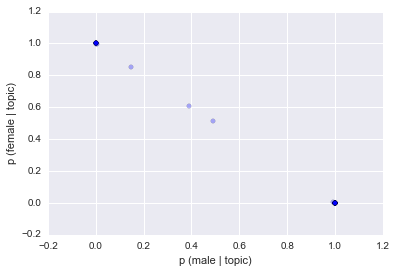

In [93]:
plt.scatter(phi.T["male"], phi.T["female"], alpha=0.3)
plt.xlabel("p (male | topic)")
plt.ylabel("p (female | topic)")

Практически все темы "моногендерные"

Добавим разреживание:

In [94]:
modals = ["@text", "@day", "@venue_categories", "@images", "@hashtags"]
T = 50
model_artm = artm.ARTM(num_topics=T, 
                      class_ids={"@text":1, "@day":1, "@venue_categories":1, \
                                 "@venue_name":1, "@images":1, "@hashtags":1,
                                 "gender":100},
                      num_document_passes=10,
                      seed=867)
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
for mod in modals:
    model_artm.scores.add(artm.TopTokensScore(name="top_"+mod[1:], 
                                              num_tokens=15, 
                                              class_id=mod))

In [95]:
model_artm.initialize(dictionary)
%time model_artm.fit_offline(batch_vectorizer=batch_vectorizer, \
                             num_collection_passes=10)

Wall time: 55 s


In [96]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', 
                                                            tau=-5*1e5, 
                                                            dictionary="dictionary",
                                                           class_ids=["@text"]))

In [97]:
%time model_artm.fit_offline(batch_vectorizer=batch_vectorizer, \
                             num_collection_passes=10)

Wall time: 1min 1s


In [98]:
for topic_name in model_artm.topic_names:
    print phi[topic_name].argmax(), "(%3f): " % phi[topic_name].max(),
    print ", ".join(model_artm.score_tracker["top_text"].last_tokens[topic_name])

male (0.992702):  badge, ale, taste, brew, flying, pumpkin, aged, fund, brewery, fruit, honey, farm, smoke, camp, pale
male (0.999996):  shoot, hero, preview, clear, mo, studio, merry, loud, speak, dashboard, color, hah, brown, boo, peace
female (0.999990):  dance, cinema, sing, surprise, cancer, screening, press, middle, singing, queen, colour, pair, bird, tune, scary
male (1.000000):  route, ran, delay, pace, leaving, private, platform, bike, traveled, speed, given, delivery, wife, quiz, despite
male (1.000000):  fulham, lad, current, joke, decent, sold, score, terrible, banter, absolute, cottage, condition, honest, draw, scene
female (0.999997):  workshop, exciting, search, library, creative, inspiring, involved, truly, hub, technique, focus, ace, rate, nature, avoid
male (0.999988):  writing, block, teacher, truly, character, straight, nearly, beyond, yr, fantasy, sausage, jake, chap, treat, lord
male (1.000000):  chip, wrote, type, faith, german, subject, camera, recently, cook, s

In [99]:
model_artm.theta_columns_naming = "title"
predict_artm = model_artm.transform(batch_vectorizer_test, predict_class_id="gender").T
predict_artm["row ID"] = predict_artm.index
predict_artm_with_gender = predict_artm.merge(london_test[["gender", "row ID"]], 
                                              on="row ID")

In [100]:
f1_score(predict_artm_with_gender["gender"].map({"female":0, "male":1}), 
         predict_artm_with_gender["male"]>0.5)

0.8045977011494253

Добавим регуляризатор декорреляции:

In [101]:
modals = ["@text", "@day", "@venue_categories", "@images", "@hashtags"]
T = 50
model_artm = artm.ARTM(num_topics=T, 
                      class_ids={"@text":1, "@day":1, "@venue_categories":1, \
                                 "@venue_name":1, "@images":1, "@hashtags":1,
                                 "gender":100},
                      num_document_passes=10,
                      seed=867)
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
for mod in modals:
    model_artm.scores.add(artm.TopTokensScore(name="top_"+mod[1:], num_tokens=15, class_id=mod))
model_artm.initialize(dictionary)
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecPhi', 
                                                            tau=10**5,
                                                           class_ids=["@text"]))
%time model_artm.fit_offline(batch_vectorizer=batch_vectorizer, \
                             num_collection_passes=10)
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', 
                                                            tau=-5*1e5, 
                                                            dictionary="dictionary",
                                                           class_ids=["@text"]))
%time model_artm.fit_offline(batch_vectorizer=batch_vectorizer, \
                             num_collection_passes=10)
model_artm.theta_columns_naming = "title"
predict_artm = model_artm.transform(batch_vectorizer_test, 
                                    predict_class_id="gender").T
predict_artm["row ID"] = predict_artm.index
predict_artm_with_gender = predict_artm.merge(london_test[["gender", "row ID"]], 
                                              on="row ID")
f1_score(predict_artm_with_gender["gender"].map({"female":0, "male":1}), 
         predict_artm_with_gender["male"]>0.5)

Wall time: 1min 2s
Wall time: 1min 1s


0.8045977011494253

__Итого:__
* Модальности позволяют инкорпорировать разные типы данных в одной модели
* Регуляризаторы улучшают качество модели
* Добаление целевого признака в качестве модальности:
    * позволяет строить ориентированные на целевой признак темы
    * автоматически настраивает параметры линейной модели для прогнозирования целевого признака
* Открытый вопрос: как оценивать качество модели?

__Что еще для исследования:__
* Мы не анализировали темы:
     * верно ли модель определяет "гендерность" темы? (визуализация)
     * поиск неочевидных сочетаний тема-пол
     * поиск "оригинальных" пользователей
* Дальнейшая переориентация модели на целевой признак:
     * поиск перманентных тем - сглаживающий регуляризатор для модальности времени
     * создание словаря "гендерных" слов и создание отдельной модальности с этими словами (с большим весм)
     
__Что еще для предсказания признака:__   
* Настройка параметров: веса модальностей, коэффициенты регуляризации, число тем...
* Другие признаки (обычно тематические профили  добавляют к исходным признакам)
* Другие алгоритмы классификации (деервья, случайные леса, нейросети...)
* Композиции алгоритмов